In [ ]:
using ComponentArrays
using Distributions
using GLMakie
using Lux
using LuxCUDA
using OptimizationOptimJL
using Random
using UnPack
using Zygote
using CairoMakie  # Backend que funciona en notebooks
using StatsBase



In [ ]:
# -------------------------------------------------------------------
# Physics-Informed Neural Network (PINN) for Solving 2D Poisson's Equation
#
# This script demonstrates how to use a neural network to solve the
# Poisson equation with Dirichlet boundary conditions in a unit square.
#
# The PINN approach embeds the PDE and boundary conditions into the loss
# function, so the neural network learns a solution that satisfies both.
# -------------------------------------------------------------------

# -------------------------------------------------------------------
# Neural Network Construction
# -------------------------------------------------------------------
# Pulso periódico gaussiano
# -------------------------------------------------------------------
# Pulso periódico gaussiano compatible con GPU
# -------------------------------------------------------------------
function pulso(x, A, sigma, x0, L)
    x_rel = mod.(x .- x0 .+ L/2, L) .- L/2
    return A .* exp.(-(x_rel.^2) ./ (2*sigma^2))
end

# ------------------------------
# Solución periódica exacta
# ------------------------------
function exact_periodic_solution(x, t, A, sigma, x0, c, L)
    return 0.5 .* (pulso(x .- c .* t, A, sigma, x0, L) .+ pulso(x .+ c .* t, A, sigma, x0, L))
end


"""
    create_neural_network(config)

Creates a fully-connected neural network (MLP) based on the configuration.
Returns the network, its parameters, and its state.
"""
function create_neural_network(config)
    @unpack N_input, N_neurons, N_layers, N_output = config

    # Initialize random number generator for reproducibility
    rng = Random.default_rng()
    Random.TaskLocalRNG()
    Random.seed!(rng)

    # Build the neural network: input layer, hidden layers, output layer
    NN = Lux.Chain(
        Lux.Dense(N_input, N_neurons, tanh),
        [Lux.Dense(N_neurons, N_neurons, tanh) for _ in 1:N_layers]...,
        Lux.Dense(N_neurons, N_output)
    )

    # Initialize parameters and state (state is unused but required)
    Θ, st = Lux.setup(rng, NN)

    # Move parameters to GPU and wrap for optimization
    Θ = Θ |> ComponentArray |> gpu_device() .|> Float64

    

    return NN, Θ, st
end

# -------------------------------------------------------------------
# Input Data Generation
# -------------------------------------------------------------------
"""
    generate_input(config)

Generates random (x, y) points in the domain as input for the PINN.
"""
function generate_input(config)
    @unpack N_points, xmin, xmax, ymin, ymax = config

    x = rand(Uniform(xmin, xmax), (1, N_points))
    y = rand(Uniform(ymin, ymax), (1, N_points))

    # Stack and move to GPU
    
    input = vcat(x, y) |> gpu_device() .|> Float64
    #input = vcat(x, y) |> gpu_device() .|> Float32

    return input
end

function generate_inputboun(config)
    @unpack N_pointsb, xmin, xmax, ymin, ymax = config

    # Generar valores de x solo en los extremos xmin y xmax
    x = reshape(rand([xmin, xmax], N_pointsb), 1, N_pointsb)

    # Generar valores de y aleatorios en el intervalo
    y = reshape(rand(Uniform(ymin, ymax), N_pointsb), 1, N_pointsb)

    # Apilar y mover a GPU
    input = vcat(x, y) |> gpu_device() .|> Float64

    return input
end


function generate_input0(config)
    @unpack N_points0, xmin, xmax, ymin, ymax = config

    x = rand(Uniform(xmin, xmax), (1, N_points0))
    y = rand(Uniform(ymin, ymax), (1, N_points0))
    y = y*0
    # Stack and move to GPU
    
    input = vcat(x, y) |> gpu_device() .|> Float64
    #input = vcat(x, y) |> gpu_device() .|> Float32

    return input
end

# -------------------------------------------------------------------
# PINN Solution Representation
# -------------------------------------------------------------------
"""
    calculate_f(x, y, NN, Θ, st)

Returns the PINN's prediction for u(x, y), enforcing Dirichlet boundary conditions.
"""
function calculate_f(x, y, NN, Θ, st)
    # Hard enforcement of boundary conditions:
    # u(x, 0) = x^2, u(0, y) = y^2, u(1, y) = 1 + y^2, u(x, 1) = 1 + x^2
    return  NN(vcat(x, y), Θ, st)[1]
end

# -------------------------------------------------------------------
# Numerical Derivatives (Finite Differences)
# -------------------------------------------------------------------
"""
    calculate_derivatives(x, y, NN, Θ, st)

Computes u, ∂²u/∂x², and ∂²u/∂y² at (x, y) using central finite differences.
"""
function calculate_derivatives(x, y, NN, Θ, st)
    ϵ = ∜(eps())  # Optimal step for second derivatives

    f = calculate_f(x, y, NN, Θ, st)
    f_xplus  = calculate_f(x .+ ϵ, y, NN, Θ, st)
    f_xminus = calculate_f(x .- ϵ, y, NN, Θ, st)
    f_yplus  = calculate_f(x, y .+ ϵ, NN, Θ, st)
    f_yminus = calculate_f(x, y .- ϵ, NN, Θ, st)

    ∂2f_∂x2 = (f_xplus .- 2 * f .+ f_xminus) / ϵ^2
    ∂2f_∂y2 = (f_yplus .- 2 * f .+ f_yminus) / ϵ^2

    return f, ∂2f_∂x2, ∂2f_∂y2
end

function calculate_df_dy(x, y, NN, Θ, st)
    ϵ = ∜(eps())  # paso óptimo para diferencias finitas

    f_yplus  = calculate_f(x, y .+ ϵ, NN, Θ, st)
    f_yminus = calculate_f(x, y .- ϵ, NN, Θ, st)

    ∂f_∂y = (f_yplus .- f_yminus) / (2 * ϵ)

    return ∂f_∂y
end


# -------------------------------------------------------------------
# Source Term and PDE Residual
# -------------------------------------------------------------------
"""
    calculate_source_term(x, y)

Returns the source term f(x, y) for the Poisson equation.
"""
calculate_source_term(x, y) = 0  # f(x, y) = 4 everywhere

"""
    poisson_equation(∂2u_∂x2, ∂2u_∂y2, source_term)

Returns the residual of the Poisson equation at each point.
"""
wave_equation(∂2u_∂x2, ∂2u_∂y2, c) = ∂2u_∂y2 .- (c^2) .* ∂2u_∂x2

# -------------------------------------------------------------------
# Loss Function
# -------------------------------------------------------------------
"""
    loss_function(input, NN, Θ, st)

Computes the mean squared error of the PDE residual over all input points.
"""
function loss_function(input, input0, inputb, NN, Θ, st)
    x, y = input[1:1, :], input[2:2, :]
    _, ∂2f_∂x2, ∂2f_∂y2 = calculate_derivatives(x, y, NN, Θ, st)
    source_term = calculate_source_term(x, y)
    eq = eq = wave_equation(∂2f_∂x2, ∂2f_∂y2, config[:c])
    loss_coll = sum(abs2, eq) / length(eq)

    x, y = input0[1:1, :], input0[2:2, :]
    u_0pinn = calculate_f(x, y, NN, Θ, st)
    u_0 = exact_periodic_solution(x, y, config[:A], config[:sigma], config[:x0], config[:c], config[:L])
    loss_u0 = sum(abs2, u_0pinn .- u_0) / length(u_0)

    x, y = inputb[1:1, :], inputb[2:2, :]
    u_bpinn = calculate_f(x, y, NN, Θ, st)
    u_b = exact_periodic_solution(x, y, config[:A], config[:sigma], config[:x0], config[:c], config[:L])
    loss_ub = sum(abs2, u_bpinn .- u_b) / length(u_b)
    
    x, y = input0[1:1, :], input0[2:2, :]
    u_t0pinn = calculate_df_dy(x, y, NN, Θ, st)    
    loss_ut0 = sum(abs2, u_t0pinn) / length(u_t0pinn)

    loss = loss_ut0 +loss_ub + loss_u0 + loss_coll

    
    

    
    return loss
end

# -------------------------------------------------------------------
# Optimization Callback
# -------------------------------------------------------------------
"""
    callback(p, l, losses)

Stores and prints the loss at each optimization step.
"""
function callback(p, l, losses)
    push!(losses, l)
    println("Current loss: ", l)
    return false
end

# -------------------------------------------------------------------
# Configuration
# -------------------------------------------------------------------
config = Dict(
    :N_input => 2,          # Number of input variables (x, y)
    :N_neurons => 40,       # Neurons per hidden layer
    :N_layers => 3,         # Number of hidden layers
    :N_output => 1,         # Output dimension (u)
    :N_points => 15000,      # Training points
    :N_pointsb => 2000,
    :N_points0 => 2000,
    :xmin => 0.0,           # Domain: x in [xmin, xmax]
    :xmax => 5.0,
    :ymin => 0.0,           # Domain: y in [ymin, ymax]
    :ymax => 1.0,
    :optimizer => BFGS(),   # Optimization algorithm
    :maxiters => 5000,      # Maximum optimization steps
    :A => 2.0,
    :sigma => 1/(200^0.5),
    :x0 => 0.5, 
    :c => 0.5,
    :L=> 5
)

# -------------------------------------------------------------------
# Training Loop
# -------------------------------------------------------------------
losses = Float64[]  # Store loss history

NN, Θ, st = create_neural_network(config)
input = generate_input(config)
input0 = generate_input0(config)
inputb = generate_inputboun(config)

# Define the optimization problem for the PINN
optf = OptimizationFunction((Θ, input) -> loss_function(input, input0, inputb, NN, Θ, st), AutoZygote())
optprob = OptimizationProblem(optf, Θ, input)
optresult = solve(
    optprob,
    callback = (p, l) -> callback(p, l, losses),
    config[:optimizer],
    maxiters = config[:maxiters],
)

# Plot loss curve
fig = Figure()
ax = GLMakie.Axis(fig[1, 1], title = "Loss vs Iterations", xlabel = "Iterations", ylabel = "Loss", yscale = log10)
lines!(ax, losses)
display(fig)

# -------------------------------------------------------------------
# Evaluation and Visualization
# -------------------------------------------------------------------
# Move optimized parameters back to CPU for evaluation
Θ = optresult.u |> cpu_device()


┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
└ @ MLDataDevices.Internal /Users/reula/.julia/packages/MLDataDevices/NeohJ/src/internal.jl:112


Current loss: 1.3232228131583623
Current loss: 

# Nuevo

Error absoluto promedio = 0.0001617458923371015


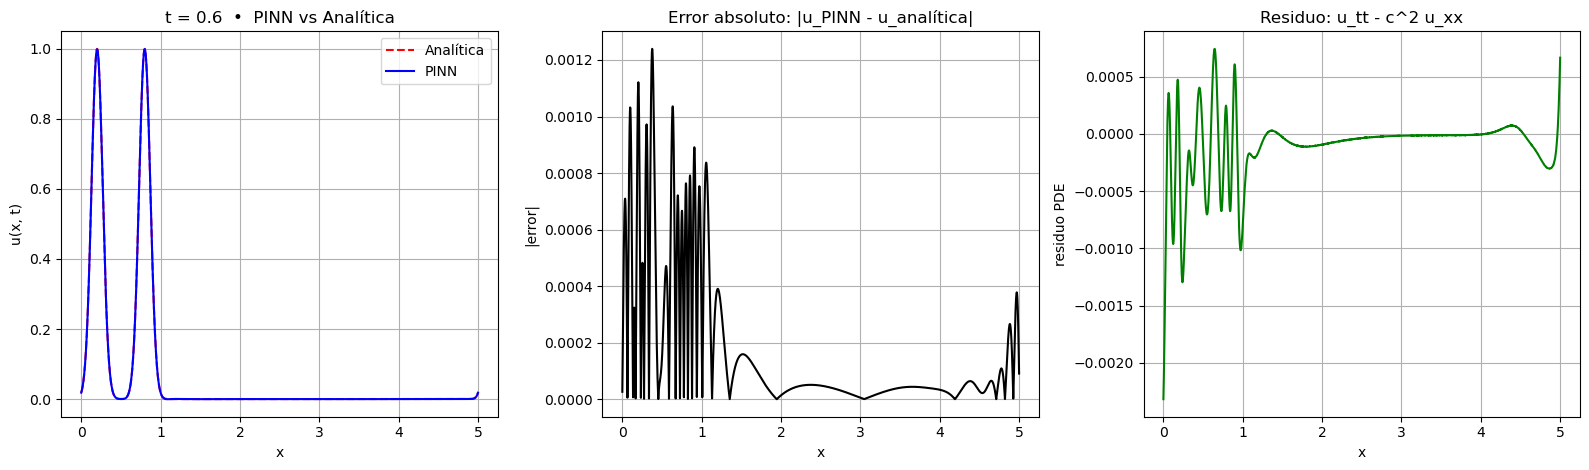

In [54]:
using PyPlot, Statistics

# ---------------------------------------------------------------
# Visualización final: 10 000 puntos, PINN vs. solución analítica
# ---------------------------------------------------------------

t_vis = 0.6 # tiempo para la comparación

# Puntos
Nvis = 10_000
xv   = collect(range(config[:xmin], config[:xmax], length = Nvis))
x    = reshape(xv, 1, :)
y    = fill(t_vis, 1, Nvis)

# Predicción PINN y solución exacta
u_pinn = calculate_f(x, y, NN, Θ, st)
u_true = exact_periodic_solution(x, y,
    config[:A], config[:sigma], config[:x0], config[:c], config[:L])

u_pinn_vec = vec(u_pinn)
u_true_vec = vec(u_true)

# Error (ahora tomamos valor absoluto para graficar)
err_vec = u_pinn_vec .- u_true_vec
abs_err_vec = abs.(err_vec)

# Residuo PDE en cada punto: r = u_tt - c^2 u_xx
_, u_xx, u_tt = calculate_derivatives(x, y, NN, Θ, st)
res_vec = vec(u_tt .- (config[:c]^2) .* u_xx)

# ---------------------------------------------------------------
# Gráficos con PyPlot (tres subplots lado a lado)
# ---------------------------------------------------------------
PyPlot.figure(figsize = (16, 4.8))

# (1) Exacta vs PINN superpuestas
PyPlot.subplot(1, 3, 1)
PyPlot.plot(xv, u_true_vec, "r--", label="Analítica")
PyPlot.plot(xv, u_pinn_vec, "b-",  label="PINN")
PyPlot.xlabel("x"); PyPlot.ylabel("u(x, t)")
PyPlot.title("t = $(round(t_vis, digits=3))  •  PINN vs Analítica")
PyPlot.grid(true); PyPlot.legend(loc="best")

# (2) Error absoluto
PyPlot.subplot(1, 3, 2)
PyPlot.plot(xv, abs_err_vec, "k-")
PyPlot.xlabel("x"); PyPlot.ylabel("|error|")
PyPlot.title("Error absoluto: |u_PINN - u_analítica|")
PyPlot.grid(true)

# (3) Residuo del PDE
PyPlot.subplot(1, 3, 3)
PyPlot.plot(xv, res_vec, "g-")
PyPlot.xlabel("x"); PyPlot.ylabel("residuo PDE")
PyPlot.title("Residuo: u_tt - c^2 u_xx")
PyPlot.grid(true)

PyPlot.tight_layout()
PyPlot.show()

# ---------------------------------------------------------------
# Error absoluto promedio
# ---------------------------------------------------------------
avg_abs_err = mean(abs_err_vec)
println("Error absoluto promedio = $avg_abs_err")


# Intengo imponer un hard enforcement tiempoo y periodicidad

Current loss: 182.74229238031737
Current loss: 176.45813659996045
Current loss: 175.12155592912353
Current loss: 174.58065373026878
Current loss: 173.6881410999184
Current loss: 171.28638208834914
Current loss: 170.83735949672226
Current loss: 170.47854620786995
Current loss: 155.67254969960644
Current loss: 154.12731990325514
Current loss: 146.61158532550726
Current loss: 145.3688881850802
Current loss: 138.1816151141549
Current loss: 136.8722823864922
Current loss: 127.56959172341622
Current loss: 126.6363200401308
Current loss: 125.76186173404288
Current loss: 124.33883664019791
Current loss: 122.6212907910301
Current loss: 120.75177514314733
Current loss: 118.15562890910812
Current loss: 116.06079000343685
Current loss: 113.57718468264841
Current loss: 111.36288718995884
Current loss: 109.55639175480461
Current loss: 107.20617037835572
Current loss: 105.63288070254114
Current loss: 103.9079140513393
Current loss: 102.3899020839249
Current loss: 100.36857821608272
Current loss: 97.9

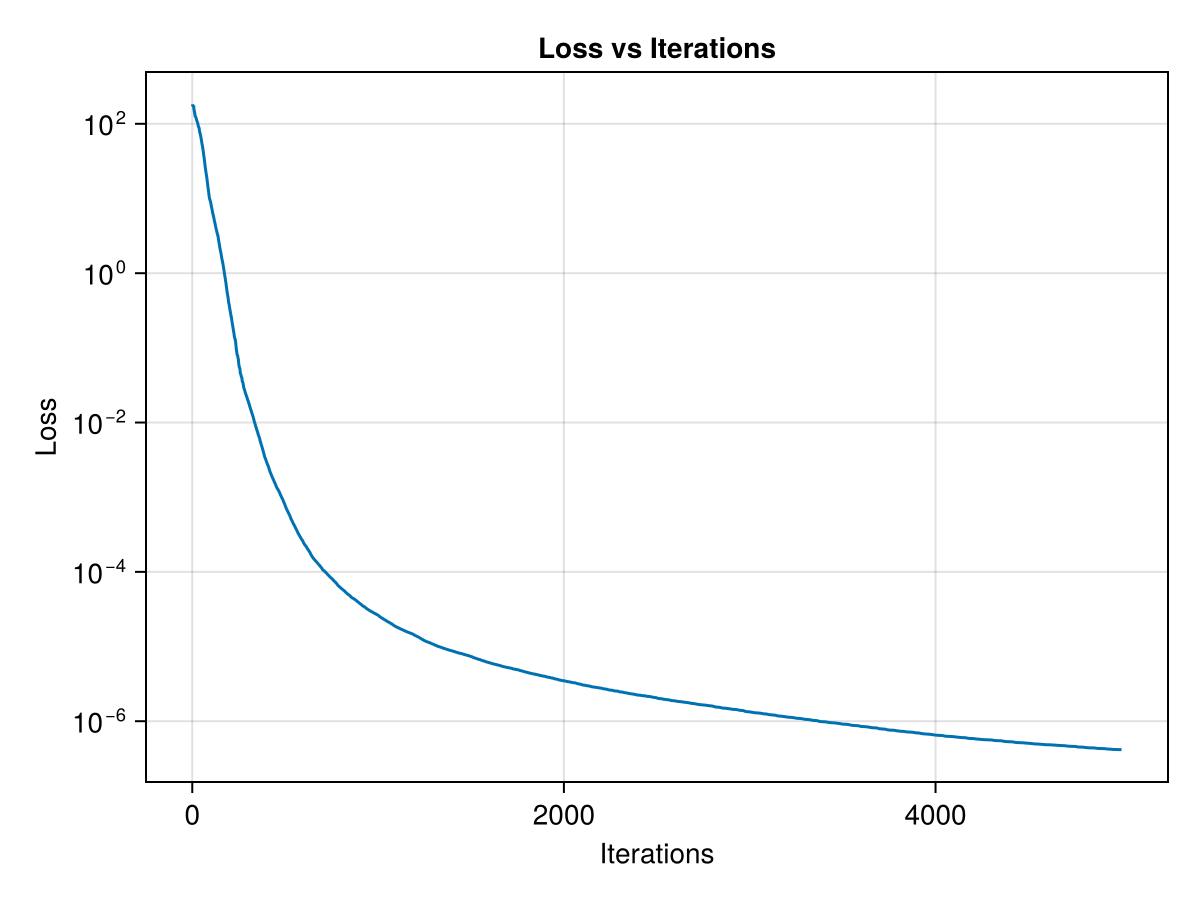

CairoMakie.Screen{IMAGE}


In [57]:
# -------------------------------------------------------------------
# PINN 1D(x)+t para la ecuación de onda: hard enforcement de
#   - periodicidad en x (periodo L) mediante sin/cos,
#   - condición inicial u(x,0)=u0(x) y ∂_t u(x,0)=0.
# El entrenamiento minimiza SOLO el residual de la PDE.
# -------------------------------------------------------------------

using Random, Distributions
using Lux, ComponentArrays
using Optimization, OptimizationOptimJL
using GLMakie

# Si usas GPU, asume que ya tienes helpers como gpu_device()/cpu_device().
# Si no, puedes definir:
# gpu_device(x) = x; cpu_device(x) = x

# -------------------------------------------------------------------
# Pulso periódico gaussiano y solución exacta periódica (para u0)
# -------------------------------------------------------------------
function pulso(x, A, sigma, x0, L)
    x_rel = mod.(x .- x0 .+ L/2, L) .- L/2
    return A .* exp.(-(x_rel.^2) ./ (2*sigma^2))
end

function exact_periodic_solution(x, t, A, sigma, x0, c, L)
    return 0.5 .* (pulso(x .- c .* t, A, sigma, x0, L) .+ pulso(x .+ c .* t, A, sigma, x0, L))
end

# -------------------------------------------------------------------
# Configuración
# -------------------------------------------------------------------
config = Dict(
    :N_input => 3,          # [sin(2πx/L); cos(2πx/L); t]
    :N_neurons => 40,
    :N_layers => 3,
    :N_output => 1,
    :N_points => 15000,     # puntos de colisión (x,t)
    :xmin => 0.0,
    :xmax => 5.0,           # = L (dominio periódico)
    :ymin => 0.0,           # t_min
    :ymax => 1.0,           # t_max
    :optimizer => BFGS(),
    :maxiters => 5000,
    :A => 2.0,
    :sigma => 1/(200^0.5),
    :x0 => 0.5,
    :c => 0.5,
    :L => 5.0
)

# -------------------------------------------------------------------
# Red neuronal
# -------------------------------------------------------------------
function create_neural_network(config)
    @unpack N_input, N_neurons, N_layers, N_output = config

    rng = Random.default_rng()
    Random.TaskLocalRNG()
    Random.seed!(rng)  # si quieres semilla fija, usa Random.seed!(rng, 1234)

    NN = Lux.Chain(
        Lux.Dense(N_input, N_neurons, tanh),
        [Lux.Dense(N_neurons, N_neurons, tanh) for _ in 1:N_layers]...,
        Lux.Dense(N_neurons, N_output)
    )
    Θ, st = Lux.setup(rng, NN)
    Θ = Θ |> ComponentArray |> gpu_device() .|> Float64
    return NN, Θ, st
end

# -------------------------------------------------------------------
# Muestreo (x,t)
# -------------------------------------------------------------------
function generate_input(config)
    @unpack N_points, xmin, xmax, ymin, ymax = config
    x = rand(Uniform(xmin, xmax), (1, N_points))
    t = rand(Uniform(ymin, ymax), (1, N_points))
    return vcat(x, t) |> gpu_device() .|> Float64
end

# -------------------------------------------------------------------
# Features periódicas y representación con hard enforcement
# -------------------------------------------------------------------
periodic_features(x, L) = vcat(sin.(2π .* x ./ L), cos.(2π .* x ./ L))

"""
u(x,t) = u0(x) + t^2 * Nθ( sin(2πx/L), cos(2πx/L), t )
- Periodicidad en x por construcción (u(x+L,t)=u(x,t)).
- u(x,0) = u0(x) exactamente.
- ∂_t u(x,0) = 0 exactamente (por el factor t^2).
"""
function calculate_f(x, t, NN, Θ, st)
    u0 = exact_periodic_solution(x, zero(t), config[:A], config[:sigma], config[:x0], config[:c], config[:L])
    ϕx = periodic_features(x, config[:L])             # (2,N)
    nn_in = vcat(ϕx, t)                               # (3,N)
    nn_out = NN(nn_in, Θ, st)[1]                      # (1,N)
    return u0 .+ (t.^2) .* nn_out
end

# -------------------------------------------------------------------
# Derivadas por diferencias finitas (segundas en x y t)
# -------------------------------------------------------------------
function calculate_derivatives(x, t, NN, Θ, st)
    ϵ = ∜(eps())  # paso óptimo para 2ª derivada aprox.

    f      = calculate_f(x, t, NN, Θ, st)
    fxp    = calculate_f(x .+ ϵ, t, NN, Θ, st)
    fxm    = calculate_f(x .- ϵ, t, NN, Θ, st)
    ftp    = calculate_f(x, t .+ ϵ, NN, Θ, st)
    ftm    = calculate_f(x, t .- ϵ, NN, Θ, st)

    ∂2f_∂x2 = (fxp .- 2 .* f .+ fxm) / ϵ^2
    ∂2f_∂t2 = (ftp .- 2 .* f .+ ftm) / ϵ^2
    return f, ∂2f_∂x2, ∂2f_∂t2
end

# -------------------------------------------------------------------
# Ecuación (onda 1D): u_tt - c^2 u_xx = 0
# -------------------------------------------------------------------
wave_equation(∂2u_∂x2, ∂2u_∂t2, c) = ∂2u_∂t2 .- (c^2) .* ∂2u_∂x2

# -------------------------------------------------------------------
# Pérdida: solo residual PDE (hard enforcement ya fija IC/periodicidad)
# -------------------------------------------------------------------
function loss_function(input, NN, Θ, st)
    x, t = input[1:1, :], input[2:2, :]
    _, u_xx, u_tt = calculate_derivatives(x, t, NN, Θ, st)
    res = wave_equation(u_xx, u_tt, config[:c])
    return sum(abs2, res) / length(res)
end

# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    push!(losses, l)
    println("Current loss: ", l)
    return false
end

# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
losses = Float64[]

NN, Θ, st = create_neural_network(config)
input = generate_input(config)

optf = OptimizationFunction((Θ, input) -> loss_function(input, NN, Θ, st), AutoZygote())
optprob = OptimizationProblem(optf, Θ, input)

optresult = solve(
    optprob,
    callback = (p, l) -> callback(p, l, losses),
    config[:optimizer],
    maxiters = config[:maxiters],
)

# Parámetros optimizados a CPU si procede
Θ = optresult.u |> cpu_device()

# Curva de pérdida
fig = Figure()
ax = GLMakie.Axis(fig[1, 1], title = "Loss vs Iterations", xlabel = "Iterations", ylabel = "Loss", yscale = log10)
lines!(ax, losses)
display(fig)


Error absoluto promedio = 1.7313792138555035e-5


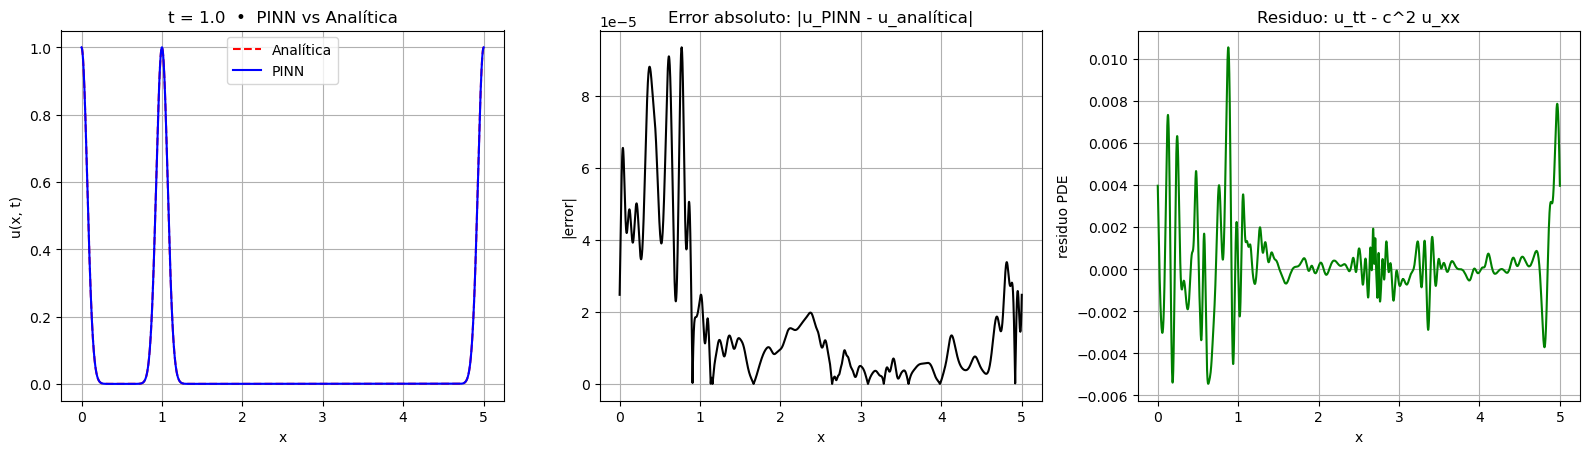

In [78]:
using PyPlot, Statistics

# ---------------------------------------------------------------
# Visualización final: 10 000 puntos, PINN vs. solución analítica
# ---------------------------------------------------------------

t_vis = 1.0 # tiempo para la comparación

# Puntos
Nvis = 10_000
xv   = collect(range(config[:xmin], config[:xmax], length = Nvis))
x    = reshape(xv, 1, :)
y    = fill(t_vis, 1, Nvis)

# Predicción PINN y solución exacta
u_pinn = calculate_f(x, y, NN, Θ, st)
u_true = exact_periodic_solution(
    x, y,
    config[:A], config[:sigma], config[:x0], config[:c], config[:L]
)

u_pinn_vec = vec(u_pinn)
u_true_vec = vec(u_true)

# Error
err_vec = u_pinn_vec .- u_true_vec
abs_err_vec = abs.(err_vec)

# Residuo PDE en cada punto: r = u_tt - c^2 u_xx
_, u_xx, u_tt = calculate_derivatives(x, y, NN, Θ, st)
res_vec = vec(u_tt .- (config[:c]^2) .* u_xx)

# ---------------------------------------------------------------
# Gráficos con PyPlot (tres subplots lado a lado)
# ---------------------------------------------------------------
PyPlot.figure(figsize = (16, 4.8))

# (1) Exacta vs PINN superpuestas
PyPlot.subplot(1, 3, 1)
PyPlot.plot(xv, u_true_vec, "r--", label="Analítica")
PyPlot.plot(xv, u_pinn_vec, "b-",  label="PINN")
PyPlot.xlabel("x"); PyPlot.ylabel("u(x, t)")
PyPlot.title("t = $(round(t_vis, digits=3))  •  PINN vs Analítica")
PyPlot.grid(true); PyPlot.legend(loc="best")

# (2) Error absoluto
PyPlot.subplot(1, 3, 2)
PyPlot.plot(xv, abs_err_vec, "k-")
PyPlot.xlabel("x"); PyPlot.ylabel("|error|")
PyPlot.title("Error absoluto: |u_PINN - u_analítica|")
PyPlot.grid(true)

# (3) Residuo del PDE
PyPlot.subplot(1, 3, 3)
PyPlot.plot(xv, res_vec, "g-")
PyPlot.xlabel("x"); PyPlot.ylabel("residuo PDE")
PyPlot.title("Residuo: u_tt - c^2 u_xx")
PyPlot.grid(true)

PyPlot.tight_layout()
PyPlot.show()

# ---------------------------------------------------------------
# Error absoluto promedio
# ---------------------------------------------------------------
avg_abs_err = mean(abs_err_vec)
println("Error absoluto promedio = $avg_abs_err")


# Randon adaptative

[ Info: RAD round 1 / 20  |  iters=500


Current loss: 193.0848946519146
Current loss: 185.33375591167626
Current loss: 180.9539592796387
Current loss: 178.83648044977406
Current loss: 170.08553752296686
Current loss: 157.78984713848232
Current loss: 154.84162751798684
Current loss: 149.66057205045794
Current loss: 145.18540831734936
Current loss: 131.32273366078618
Current loss: 121.57947158202731
Current loss: 114.75317917634956
Current loss: 106.10222836297572
Current loss: 99.72908336874478
Current loss: 93.3700178944524
Current loss: 87.40382217682938
Current loss: 78.68250426491977
Current loss: 73.9361964470298
Current loss: 71.69747462873781
Current loss: 63.81608912777788
Current loss: 59.48551791902698
Current loss: 56.1918961573033
Current loss: 51.14019178491432
Current loss: 47.543624810775185
Current loss: 45.72242598035624
Current loss: 43.98568219973032
Current loss: 42.20709418565014
Current loss: 39.484091820719655
Current loss: 37.475363655788506
Current loss: 35.84516769316919
Current loss: 33.489477000563

[ Info: RAD round 2 / 20  |  iters=500


Current loss: 0.0012333620969196036
Current loss: 0.0012292034604974534
Current loss: 0.0012148464773638014
Current loss: 0.001205840058101642
Current loss: 0.0011974072408081071
Current loss: 0.0011842107085290503
Current loss: 0.0011712214187677447
Current loss: 0.0011596859273828475
Current loss: 0.0011432823592592788
Current loss: 0.0011321117479430928
Current loss: 0.0011133478316310867
Current loss: 0.0010962610980138042
Current loss: 0.0010850314030591644
Current loss: 0.0010731006240770559
Current loss: 0.0010651716942016495
Current loss: 0.0010535067004447314
Current loss: 0.001045566977078086
Current loss: 0.0010358872606789531
Current loss: 0.0010272214024962508
Current loss: 0.0010202649665529793
Current loss: 0.0010128215728094417
Current loss: 0.001006722591766746
Current loss: 0.0009983344536330784
Current loss: 0.0009904553707508605
Current loss: 0.000984538080002146
Current loss: 0.0009796048343694431
Current loss: 0.0009661280551851828
Current loss: 0.0009574641750496

[ Info: RAD round 3 / 20  |  iters=500


Current loss: 4.1914602194923625e-5
Current loss: 4.166070681584012e-5
Current loss: 4.1166023714263685e-5
Current loss: 4.096461415984712e-5
Current loss: 4.073338840859518e-5
Current loss: 4.05675985069301e-5
Current loss: 4.0422810724447604e-5
Current loss: 4.028413553316039e-5
Current loss: 4.0111119404510154e-5
Current loss: 4.001507844950501e-5
Current loss: 3.9928648293186354e-5
Current loss: 3.979509773510455e-5
Current loss: 3.965353430488177e-5
Current loss: 3.950424768696962e-5
Current loss: 3.9388822130225723e-5
Current loss: 3.9242932681283755e-5
Current loss: 3.908463465104568e-5
Current loss: 3.8994007094033666e-5
Current loss: 3.8938888777642465e-5
Current loss: 3.881549066649261e-5
Current loss: 3.8716152831006964e-5
Current loss: 3.855844751559062e-5
Current loss: 3.843265734821178e-5
Current loss: 3.835934411990572e-5
Current loss: 3.826721247185242e-5
Current loss: 3.816647713327674e-5
Current loss: 3.808390514311961e-5
Current loss: 3.792591133345889e-5
Current los

[ Info: RAD round 4 / 20  |  iters=500


Current loss: 2.0660832784222264e-5
Current loss: 2.0379887331608217e-5
Current loss: 2.026270150551636e-5
Current loss: 2.017533556798415e-5
Current loss: 2.0017947381272598e-5
Current loss: 1.9668443515265877e-5
Current loss: 1.9450513301704606e-5
Current loss: 1.9295978326952962e-5
Current loss: 1.920345693691999e-5
Current loss: 1.9058224679660547e-5
Current loss: 1.8876779727894132e-5
Current loss: 1.8771040861562662e-5
Current loss: 1.8654187852255962e-5
Current loss: 1.848201985813566e-5
Current loss: 1.8369120691074684e-5
Current loss: 1.827392760874694e-5
Current loss: 1.818315656386508e-5
Current loss: 1.807848781231416e-5
Current loss: 1.8012282663597897e-5
Current loss: 1.7942435734843154e-5
Current loss: 1.7894226626989895e-5
Current loss: 1.7830078073427704e-5
Current loss: 1.7777619237818977e-5
Current loss: 1.7680905293519934e-5
Current loss: 1.763256276479645e-5
Current loss: 1.7587815841809324e-5
Current loss: 1.7505829794787393e-5
Current loss: 1.7453179095531446e-5


[ Info: RAD round 5 / 20  |  iters=500


Current loss: 2.5813490717738245e-5
Current loss: 2.480526138274624e-5
Current loss: 2.4185150762420715e-5
Current loss: 2.3559548655397515e-5
Current loss: 2.2804555932559858e-5
Current loss: 2.21061246457202e-5
Current loss: 2.1394345193397225e-5
Current loss: 2.1071569112534228e-5
Current loss: 2.0773691665745216e-5
Current loss: 2.0454188471342253e-5
Current loss: 2.0053834096294375e-5
Current loss: 1.972365840272182e-5
Current loss: 1.9403469906451695e-5
Current loss: 1.9110625937432225e-5
Current loss: 1.887501334204345e-5
Current loss: 1.8715450707079767e-5
Current loss: 1.848344194033236e-5
Current loss: 1.8282794874349896e-5
Current loss: 1.8031615716700855e-5
Current loss: 1.7797170321308444e-5
Current loss: 1.7660367987125594e-5
Current loss: 1.7493521716999568e-5
Current loss: 1.7315540534077312e-5
Current loss: 1.71685608921203e-5
Current loss: 1.7086790665557632e-5
Current loss: 1.6987022093526378e-5
Current loss: 1.6836640646848125e-5
Current loss: 1.6710764987378203e-5


[ Info: RAD round 6 / 20  |  iters=500


Current loss: 7.332283816408676e-6
Current loss: 7.238884876446358e-6
Current loss: 7.206541111236078e-6
Current loss: 7.102544690507597e-6
Current loss: 7.060862344760037e-6
Current loss: 6.945650229439815e-6
Current loss: 6.912019948885369e-6
Current loss: 6.879534120757938e-6
Current loss: 6.841164346273259e-6
Current loss: 6.780478757422268e-6
Current loss: 6.72392703418816e-6
Current loss: 6.688808421630334e-6
Current loss: 6.652356129005713e-6
Current loss: 6.599575446290481e-6
Current loss: 6.562587175752913e-6
Current loss: 6.5195279909443055e-6
Current loss: 6.469016643264386e-6
Current loss: 6.434707314878916e-6
Current loss: 6.381855572123628e-6
Current loss: 6.341260583017359e-6
Current loss: 6.309382703150189e-6
Current loss: 6.284141785787155e-6
Current loss: 6.249027373888255e-6
Current loss: 6.201206798517785e-6
Current loss: 6.181613737130444e-6
Current loss: 6.163406030821644e-6
Current loss: 6.136734781733399e-6
Current loss: 6.111242605897957e-6
Current loss: 6.0731

[ Info: RAD round 7 / 20  |  iters=500


Current loss: 5.886491455465906e-6
Current loss: 5.762570910890426e-6
Current loss: 5.737027641202709e-6
Current loss: 5.676782871146595e-6
Current loss: 5.613806911920119e-6
Current loss: 5.5641681340818546e-6
Current loss: 5.490790285220791e-6
Current loss: 5.460162948702033e-6
Current loss: 5.420848029612727e-6
Current loss: 5.362570161720357e-6
Current loss: 5.299526941950657e-6
Current loss: 5.25396397470973e-6
Current loss: 5.229674897308577e-6
Current loss: 5.2079396327260905e-6
Current loss: 5.193058751681721e-6
Current loss: 5.1703026384485225e-6
Current loss: 5.147429251012877e-6
Current loss: 5.128907199041169e-6
Current loss: 5.102411236940016e-6
Current loss: 5.083427174172435e-6
Current loss: 5.0620678483861425e-6
Current loss: 5.044316511883445e-6
Current loss: 5.031942657812303e-6
Current loss: 5.005978933414455e-6
Current loss: 4.979917174847753e-6
Current loss: 4.9462000690390104e-6
Current loss: 4.9333416847980345e-6
Current loss: 4.899168714194133e-6
Current loss: 4

[ Info: RAD round 8 / 20  |  iters=500


Current loss: 3.8044784313675796e-6
Current loss: 3.7584848900783642e-6
Current loss: 3.712052884598946e-6
Current loss: 3.6949712857799968e-6
Current loss: 3.6496859292019357e-6
Current loss: 3.603095477487798e-6
Current loss: 3.5702033549697395e-6
Current loss: 3.5398939712857144e-6
Current loss: 3.5228508619654106e-6
Current loss: 3.5003719965886676e-6
Current loss: 3.456526372547871e-6
Current loss: 3.432069418963854e-6
Current loss: 3.4178560922187165e-6
Current loss: 3.392025709286454e-6
Current loss: 3.3685271074490738e-6
Current loss: 3.354563474982193e-6
Current loss: 3.3357017754326838e-6
Current loss: 3.3139970638311773e-6
Current loss: 3.2937193678690985e-6
Current loss: 3.273372109104772e-6
Current loss: 3.265271679146725e-6
Current loss: 3.252328237461046e-6
Current loss: 3.2424000706168176e-6
Current loss: 3.2325372993528606e-6
Current loss: 3.221984503998059e-6
Current loss: 3.211687456788573e-6
Current loss: 3.1971728170338907e-6
Current loss: 3.1876205932722604e-6
Cur

[ Info: RAD round 9 / 20  |  iters=500


Current loss: 3.363419123175984e-6
Current loss: 3.353803100345944e-6
Current loss: 3.337887469366925e-6
Current loss: 3.320587391506296e-6
Current loss: 3.2881504612222817e-6
Current loss: 3.2660940074405083e-6
Current loss: 3.236925605420537e-6
Current loss: 3.214060665702801e-6
Current loss: 3.1977429476201886e-6
Current loss: 3.1849283843870655e-6
Current loss: 3.168152323090427e-6
Current loss: 3.146925524150964e-6
Current loss: 3.131255991719453e-6
Current loss: 3.1149968438470083e-6
Current loss: 3.099537770593982e-6
Current loss: 3.0894963923362194e-6
Current loss: 3.07792087411271e-6
Current loss: 3.06453530466346e-6
Current loss: 3.053994273925314e-6
Current loss: 3.040612757166043e-6
Current loss: 3.024042141104141e-6
Current loss: 3.014763056405633e-6
Current loss: 3.005403436080212e-6
Current loss: 2.9986169815802295e-6
Current loss: 2.99170604276482e-6
Current loss: 2.982646072770532e-6
Current loss: 2.9720412774851083e-6
Current loss: 2.96621424111346e-6
Current loss: 2.

[ Info: RAD round 10 / 20  |  iters=500


Current loss: 3.080780214173812e-6
Current loss: 3.052685856741753e-6
Current loss: 3.0013073687845533e-6
Current loss: 2.9813223490208842e-6
Current loss: 2.967285299277415e-6
Current loss: 2.95500527990005e-6
Current loss: 2.9358862652505195e-6
Current loss: 2.9127554435073005e-6
Current loss: 2.8892773448767397e-6
Current loss: 2.864454593979694e-6
Current loss: 2.8394942564613835e-6
Current loss: 2.803669609639233e-6
Current loss: 2.7800704083221623e-6
Current loss: 2.7515612744549693e-6
Current loss: 2.7268818040357682e-6
Current loss: 2.7065634719126405e-6
Current loss: 2.6894641807838607e-6
Current loss: 2.6693687441981243e-6
Current loss: 2.653209339499448e-6
Current loss: 2.634574156265132e-6
Current loss: 2.6115708539891174e-6
Current loss: 2.596443060234968e-6
Current loss: 2.569143507945274e-6
Current loss: 2.5533033648939904e-6
Current loss: 2.5413534699287314e-6
Current loss: 2.5282687320165833e-6
Current loss: 2.5109156870172767e-6
Current loss: 2.4917551827190817e-6
Cur

[ Info: RAD round 11 / 20  |  iters=500


Current loss: 2.4515640713202498e-6
Current loss: 2.4366288526818007e-6
Current loss: 2.401025671079518e-6
Current loss: 2.3813955816079987e-6
Current loss: 2.362928479818373e-6
Current loss: 2.3499678908628417e-6
Current loss: 2.3220304220454624e-6
Current loss: 2.3026913023969175e-6
Current loss: 2.2816786998702345e-6
Current loss: 2.25278186747421e-6
Current loss: 2.230855070710595e-6
Current loss: 2.2112236901582315e-6
Current loss: 2.1976894501141506e-6
Current loss: 2.187275154400008e-6
Current loss: 2.1741395847627393e-6
Current loss: 2.16330320122595e-6
Current loss: 2.156450313454063e-6
Current loss: 2.1489326093128583e-6
Current loss: 2.142063911193464e-6
Current loss: 2.1300478878626316e-6
Current loss: 2.1196832525611043e-6
Current loss: 2.1102207682556096e-6
Current loss: 2.1008426841703452e-6
Current loss: 2.094989114011706e-6
Current loss: 2.090241059721376e-6
Current loss: 2.0855286794349914e-6
Current loss: 2.0784809090283127e-6
Current loss: 2.0689879455764426e-6
Curr

[ Info: RAD round 12 / 20  |  iters=500


Current loss: 1.633693668514891e-6
Current loss: 1.626261802187405e-6
Current loss: 1.6195252441988202e-6
Current loss: 1.616256778911954e-6
Current loss: 1.6108482981290588e-6
Current loss: 1.6014475038633568e-6
Current loss: 1.5925653361347297e-6
Current loss: 1.5869422123736362e-6
Current loss: 1.5802057003403822e-6
Current loss: 1.576881158928602e-6
Current loss: 1.5742001508942523e-6
Current loss: 1.56952180425441e-6
Current loss: 1.5638706772902551e-6
Current loss: 1.5578478288502862e-6
Current loss: 1.5542812351404109e-6
Current loss: 1.5493130754001638e-6
Current loss: 1.543773095417425e-6
Current loss: 1.536338019964841e-6
Current loss: 1.532157052998833e-6
Current loss: 1.5279724593676449e-6
Current loss: 1.5251187310393314e-6
Current loss: 1.5219829408309941e-6
Current loss: 1.5169904567005523e-6
Current loss: 1.514300447619555e-6
Current loss: 1.5106887195275781e-6
Current loss: 1.5066727502979965e-6
Current loss: 1.5026458410328704e-6
Current loss: 1.4997145519013087e-6
Cu

[ Info: RAD round 13 / 20  |  iters=500


Current loss: 1.386100680233693e-6
Current loss: 1.3754141920100505e-6
Current loss: 1.3690401927807455e-6
Current loss: 1.3652054471242598e-6
Current loss: 1.3586284687786509e-6
Current loss: 1.3488861223136412e-6
Current loss: 1.3411598162712868e-6
Current loss: 1.3357340622219807e-6
Current loss: 1.3317755670851832e-6
Current loss: 1.3270477150738699e-6
Current loss: 1.32182722925419e-6
Current loss: 1.317418989660392e-6
Current loss: 1.3124609915053117e-6
Current loss: 1.308145044878725e-6
Current loss: 1.3046105464577918e-6
Current loss: 1.3009886107571842e-6
Current loss: 1.2986104581629755e-6
Current loss: 1.2950558550398944e-6
Current loss: 1.2880257356346819e-6
Current loss: 1.2839397213047397e-6
Current loss: 1.2800689457580747e-6
Current loss: 1.2763846085444519e-6
Current loss: 1.2737409645846e-6
Current loss: 1.270943127195846e-6
Current loss: 1.2652167232670828e-6
Current loss: 1.2613756869677703e-6
Current loss: 1.2587553301175744e-6
Current loss: 1.2541318236205168e-6
C

[ Info: RAD round 14 / 20  |  iters=500


Current loss: 1.3337950036616223e-6
Current loss: 1.322532797006224e-6
Current loss: 1.314607628058317e-6
Current loss: 1.3070607379494173e-6
Current loss: 1.2989031619454055e-6
Current loss: 1.2903927530971897e-6
Current loss: 1.2821127393662896e-6
Current loss: 1.2762479239427943e-6
Current loss: 1.2717655246285068e-6
Current loss: 1.2672224342787435e-6
Current loss: 1.2630878126440676e-6
Current loss: 1.2529223768273358e-6
Current loss: 1.246860635312319e-6
Current loss: 1.2408877227546066e-6
Current loss: 1.2333490833944099e-6
Current loss: 1.2287909293181261e-6
Current loss: 1.2261736273048113e-6
Current loss: 1.2219700703188261e-6
Current loss: 1.218308862144364e-6
Current loss: 1.2126412886841217e-6
Current loss: 1.2087377488074309e-6
Current loss: 1.2051853455147964e-6
Current loss: 1.201703887151577e-6
Current loss: 1.199537569468444e-6
Current loss: 1.195682481380482e-6
Current loss: 1.1918513820125918e-6
Current loss: 1.1876700931218627e-6
Current loss: 1.1824620521871823e-6

[ Info: RAD round 15 / 20  |  iters=500


Current loss: 1.294707532131204e-6
Current loss: 1.2599891538607976e-6
Current loss: 1.2547279216416397e-6
Current loss: 1.2495059989077426e-6
Current loss: 1.2378818859250517e-6
Current loss: 1.2193071024490262e-6
Current loss: 1.2077981254759573e-6
Current loss: 1.2012249893475477e-6
Current loss: 1.1936660806965028e-6
Current loss: 1.1863351648022355e-6
Current loss: 1.1754042567767294e-6
Current loss: 1.1652792746194783e-6
Current loss: 1.15795420644313e-6
Current loss: 1.152877704523519e-6
Current loss: 1.1484879740113154e-6
Current loss: 1.1446785617322776e-6
Current loss: 1.1407135692376782e-6
Current loss: 1.1343980563454952e-6
Current loss: 1.1267385567073916e-6
Current loss: 1.1221964051646954e-6
Current loss: 1.1163620222855993e-6
Current loss: 1.1121175192387126e-6
Current loss: 1.1081949474973795e-6
Current loss: 1.1044648100823263e-6
Current loss: 1.099034618135834e-6
Current loss: 1.0948383466975823e-6
Current loss: 1.090816788294894e-6
Current loss: 1.0878198208620871e-

[ Info: RAD round 16 / 20  |  iters=500


Current loss: 1.0562510794001617e-6
Current loss: 1.0397321679727037e-6
Current loss: 1.035925944166398e-6
Current loss: 1.029934705269297e-6
Current loss: 1.02715336635309e-6
Current loss: 1.0226653495384861e-6
Current loss: 1.016515229752466e-6
Current loss: 1.0105210027518432e-6
Current loss: 1.0032249045964758e-6
Current loss: 9.975651785040717e-7
Current loss: 9.930942919400213e-7
Current loss: 9.883852984240283e-7
Current loss: 9.844601407565305e-7
Current loss: 9.799609340649415e-7
Current loss: 9.755495731453942e-7
Current loss: 9.711020504435892e-7
Current loss: 9.684309065377291e-7
Current loss: 9.655769783172683e-7
Current loss: 9.620860414554921e-7
Current loss: 9.601741398717286e-7
Current loss: 9.577128613409912e-7
Current loss: 9.560113290995153e-7
Current loss: 9.529467950561964e-7
Current loss: 9.497670896807551e-7
Current loss: 9.476182363949498e-7
Current loss: 9.453085668547219e-7
Current loss: 9.429116726274873e-7
Current loss: 9.411964765194919e-7
Current loss: 9.

[ Info: RAD round 17 / 20  |  iters=500


Current loss: 9.129564726732962e-7
Current loss: 8.99224593493541e-7
Current loss: 8.803303439225179e-7
Current loss: 8.700367077756562e-7
Current loss: 8.674491893911704e-7
Current loss: 8.598475135845808e-7
Current loss: 8.515458842486894e-7
Current loss: 8.451820747811452e-7
Current loss: 8.392921581713705e-7
Current loss: 8.31942227346699e-7
Current loss: 8.289125766877361e-7
Current loss: 8.251511067417757e-7
Current loss: 8.199141305982516e-7
Current loss: 8.154497963455624e-7
Current loss: 8.117993497506354e-7
Current loss: 8.086496715257012e-7
Current loss: 8.05211312952402e-7
Current loss: 8.037612567204535e-7
Current loss: 8.021294451709138e-7
Current loss: 8.00054294648375e-7
Current loss: 7.989539012872003e-7
Current loss: 7.968844502539684e-7
Current loss: 7.955932387314003e-7
Current loss: 7.937933417140214e-7
Current loss: 7.920205413903581e-7
Current loss: 7.91382646754433e-7
Current loss: 7.899892098117006e-7
Current loss: 7.887824915898382e-7
Current loss: 7.868167760

[ Info: RAD round 18 / 20  |  iters=500


Current loss: 1.3076878385647634e-6
Current loss: 1.286303057402057e-6
Current loss: 1.2230568964543471e-6
Current loss: 1.2151433973026292e-6
Current loss: 1.1879069670571428e-6
Current loss: 1.1763722571513099e-6
Current loss: 1.1630284840572113e-6
Current loss: 1.1492025187344396e-6
Current loss: 1.139710195525484e-6
Current loss: 1.1257841216569295e-6
Current loss: 1.11293206685429e-6
Current loss: 1.0920669630466228e-6
Current loss: 1.0716228689959951e-6
Current loss: 1.052405720827321e-6
Current loss: 1.0444635994313485e-6
Current loss: 1.037069292673937e-6
Current loss: 1.0283627886380319e-6
Current loss: 1.021518059400249e-6
Current loss: 1.0157489090618803e-6
Current loss: 1.008399092885266e-6
Current loss: 1.0035455630500937e-6
Current loss: 9.989010914511608e-7
Current loss: 9.946768155513058e-7
Current loss: 9.886393755041188e-7
Current loss: 9.85015105838142e-7
Current loss: 9.791641083642476e-7
Current loss: 9.729616232076697e-7
Current loss: 9.677482476873751e-7
Current 

[ Info: RAD round 19 / 20  |  iters=500


Current loss: 8.150702406656382e-7
Current loss: 8.062262085253325e-7
Current loss: 7.944983488543613e-7
Current loss: 7.905696210299876e-7
Current loss: 7.864840896019225e-7
Current loss: 7.848302722354986e-7
Current loss: 7.80841497865478e-7
Current loss: 7.732905379423223e-7
Current loss: 7.663082405237231e-7
Current loss: 7.60846370664486e-7
Current loss: 7.56255709577469e-7
Current loss: 7.508929322159503e-7
Current loss: 7.45656164569126e-7
Current loss: 7.41540248618746e-7
Current loss: 7.374405517375758e-7
Current loss: 7.342731760549409e-7
Current loss: 7.305792065654966e-7
Current loss: 7.278470809426174e-7
Current loss: 7.250672374808105e-7
Current loss: 7.217621281767859e-7
Current loss: 7.191922020122129e-7
Current loss: 7.155895500461462e-7
Current loss: 7.127787362655054e-7
Current loss: 7.107978033398046e-7
Current loss: 7.081554740251361e-7
Current loss: 7.04808264718483e-7
Current loss: 7.015154102203276e-7
Current loss: 6.992233954840794e-7
Current loss: 6.9667118175

[ Info: RAD round 20 / 20  |  iters=500


Current loss: 7.806770013486057e-7
Current loss: 7.755346733179609e-7
Current loss: 7.672605133481452e-7
Current loss: 7.648038139583389e-7
Current loss: 7.617508078254301e-7
Current loss: 7.590594438997956e-7
Current loss: 7.560156511109262e-7
Current loss: 7.520168275702316e-7
Current loss: 7.50096578377881e-7
Current loss: 7.475556707065436e-7
Current loss: 7.454310393651333e-7
Current loss: 7.422250348997366e-7
Current loss: 7.396880128158473e-7
Current loss: 7.371861931790501e-7
Current loss: 7.346489178057591e-7
Current loss: 7.313671227622841e-7
Current loss: 7.285574281568528e-7
Current loss: 7.258276373824499e-7
Current loss: 7.241146362115265e-7
Current loss: 7.212258213562413e-7
Current loss: 7.18965081308215e-7
Current loss: 7.175470450510973e-7
Current loss: 7.149744900968909e-7
Current loss: 7.132473619531721e-7
Current loss: 7.118727029474806e-7
Current loss: 7.09091631858038e-7
Current loss: 7.068021397653269e-7
Current loss: 7.047380266842635e-7
Current loss: 7.0179410

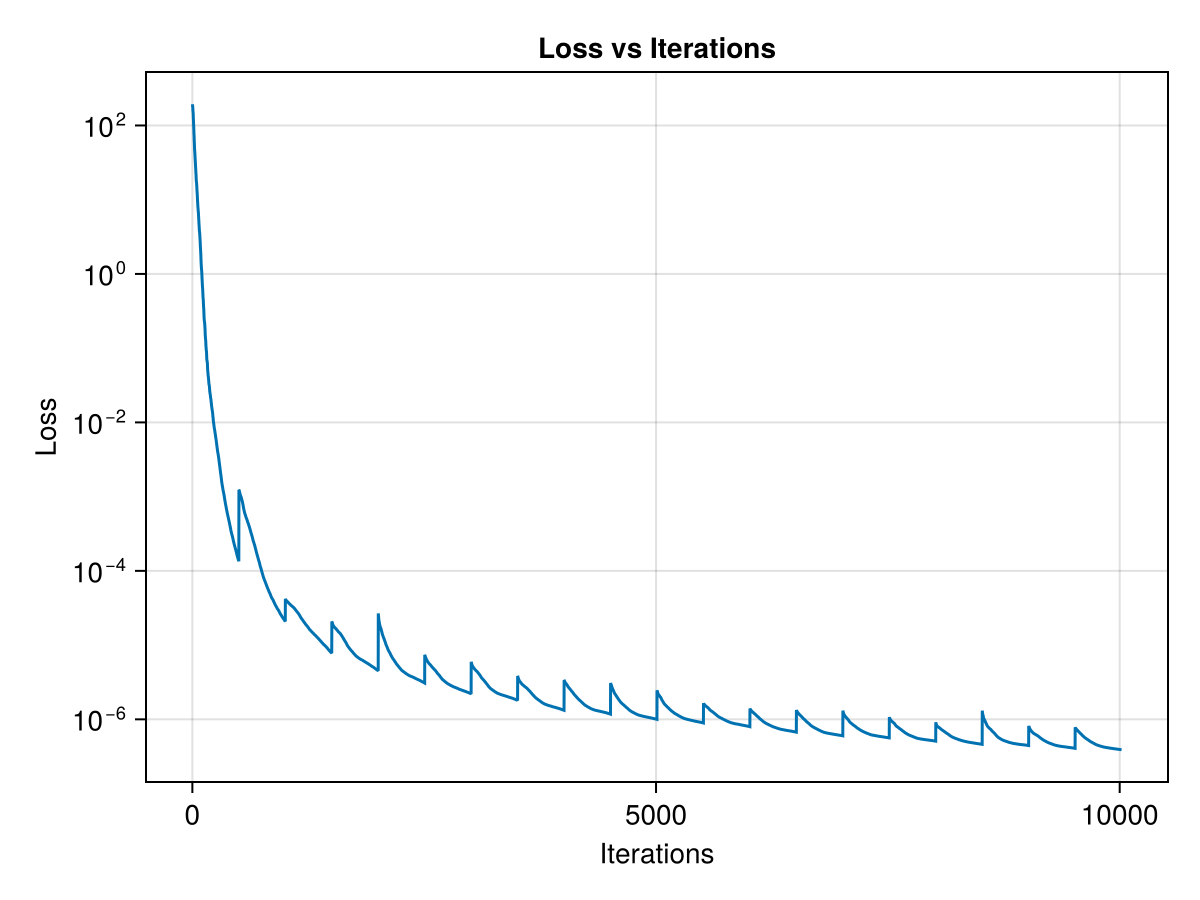

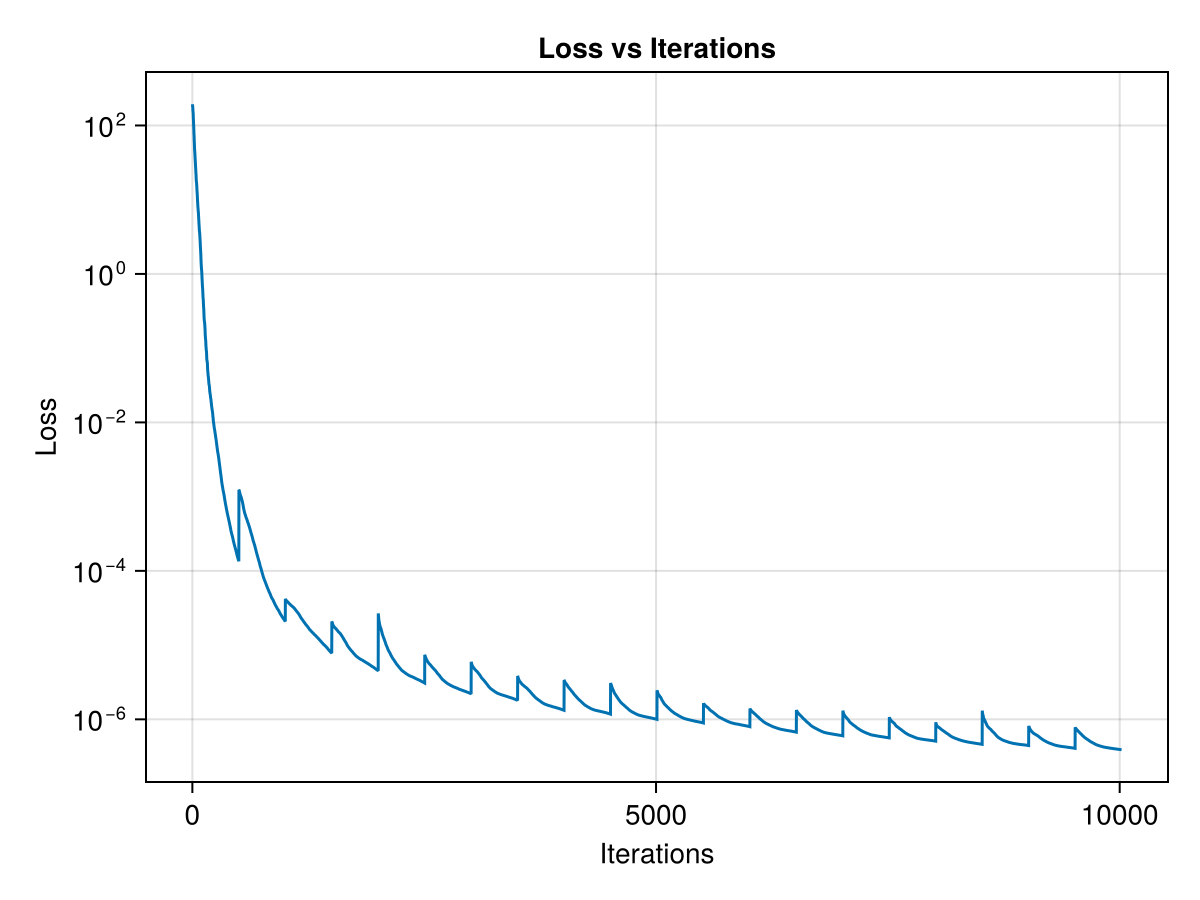

CairoMakie.Screen{IMAGE}


In [89]:
# -------------------------------------------------------------------
# PINN 1D(x)+t para la ecuación de onda: hard enforcement de
#   - periodicidad en x (periodo L) mediante sin/cos,
#   - condición inicial u(x,0)=u0(x) y ∂_t u(x,0)=0.
# El entrenamiento minimiza SOLO el residual de la PDE.
# -------------------------------------------------------------------

using Random, Distributions
using Lux, ComponentArrays
using Optimization, OptimizationOptimJL
using GLMakie

# Si usas GPU, asume que ya tienes helpers como gpu_device()/cpu_device().
# Si no, puedes definir:
# gpu_device(x) = x; cpu_device(x) = x

# -------------------------------------------------------------------
# Pulso periódico gaussiano y solución exacta periódica (para u0)
# -------------------------------------------------------------------
function pulso(x, A, sigma, x0, L)
    x_rel = mod.(x .- x0 .+ L/2, L) .- L/2
    return A .* exp.(-(x_rel.^2) ./ (2*sigma^2))
end

function exact_periodic_solution(x, t, A, sigma, x0, c, L)
    return 0.5 .* (pulso(x .- c .* t, A, sigma, x0, L) .+ pulso(x .+ c .* t, A, sigma, x0, L))
end

# -------------------------------------------------------------------
# Configuración
# -------------------------------------------------------------------
config = Dict(
    :N_input => 3,          # [sin(2πx/L); cos(2πx/L); t]
    :N_neurons => 40,
    :N_layers => 3,
    :N_output => 1,
    :N_points => 15000,     # puntos de colisión (x,t)
    :xmin => 0.0,
    :xmax => 5.0,           # = L (dominio periódico)
    :ymin => 0.0,           # t_min
    :ymax => 1.0,           # t_max
    :optimizer => BFGS(),
    :maxiters => 5000,
    :A => 2.0,
    :sigma => 1/(200^0.5),
    :x0 => 0.5,
    :c => 0.5,
    :L => 5.0
)

# -------------------------------------------------------------------
# Red neuronal
# -------------------------------------------------------------------
function create_neural_network(config)
    @unpack N_input, N_neurons, N_layers, N_output = config

    rng = Random.default_rng()
    Random.TaskLocalRNG()
    Random.seed!(rng)  # si quieres semilla fija, usa Random.seed!(rng, 1234)

    NN = Lux.Chain(
        Lux.Dense(N_input, N_neurons, tanh),
        [Lux.Dense(N_neurons, N_neurons, tanh) for _ in 1:N_layers]...,
        Lux.Dense(N_neurons, N_output)
    )
    Θ, st = Lux.setup(rng, NN)
    Θ = Θ |> ComponentArray |> gpu_device() .|> Float64
    return NN, Θ, st
end

# -------------------------------------------------------------------
# Muestreo (x,t)
# -------------------------------------------------------------------
# Candidatos uniformes (igual que generate_input, pero con N variable)
function generate_inputs(N::Int, config)
    @unpack xmin, xmax, ymin, ymax = config
    x = rand(Uniform(xmin, xmax), (1, N))
    t = rand(Uniform(ymin, ymax), (1, N))
    return vcat(x, t) |> gpu_device() .|> Float64
end

# Residuo (u_tt - c^2 u_xx) en cada punto (vector)
function residual_at_points(input, NN, Θ, st, config)
    x, t = input[1:1, :], input[2:2, :]
    _, u_xx, u_tt = calculate_derivatives(x, t, NN, Θ, st)
    res = wave_equation(u_xx, u_tt, config[:c])
    return vec(abs.(res |> cpu_device()))  # magnitud del residuo en CPU
end

"""
adaptive_rad:
  - Ntest: nº de candidatos uniformes que se generan
  - Nint: nº de puntos que quieres seleccionar para entrenar
  - k1, k2: hiperparámetros RAD (ponderación por |residuo|^k1, desplazamiento k2)
Devuelve un 'input' de tamaño (2, Nint) ponderado por el residuo.
"""
function adaptive_rad(NN, Θ, st, config; Ntest=50_000, Nint=config[:N_points], k1=1.0, k2=1e-6)
    Xtest = generate_inputs(Ntest, config)
    Y = residual_at_points(Xtest, NN, Θ, st, config)        # |residuo| en cada punto
    w = (Y .^ k1)
    w = w ./ mean(w) .+ k2                                  # normalización + desplazamiento
    p = w ./ sum(w)                                         # distribución de probabilidad
    ids = sample(1:length(p), Weights(p), Nint; replace=false)
    return Xtest[:, ids]                                     # (2, Nint)
end


# -------------------------------------------------------------------
# Features periódicas y representación con hard enforcement
# -------------------------------------------------------------------
periodic_features(x, L) = vcat(sin.(2π .* x ./ L), cos.(2π .* x ./ L))

"""
u(x,t) = u0(x) + t^2 * Nθ( sin(2πx/L), cos(2πx/L), t )
- Periodicidad en x por construcción (u(x+L,t)=u(x,t)).
- u(x,0) = u0(x) exactamente.
- ∂_t u(x,0) = 0 exactamente (por el factor t^2).
"""
function calculate_f(x, t, NN, Θ, st)
    u0 = exact_periodic_solution(x, zero(t), config[:A], config[:sigma], config[:x0], config[:c], config[:L])
    ϕx = periodic_features(x, config[:L])             # (2,N)
    nn_in = vcat(ϕx, t)                               # (3,N)
    nn_out = NN(nn_in, Θ, st)[1]                      # (1,N)
    return u0 .+ (t.^2) .* nn_out
end

# -------------------------------------------------------------------
# Derivadas por diferencias finitas (segundas en x y t)
# -------------------------------------------------------------------
function calculate_derivatives(x, t, NN, Θ, st)
    ϵ = ∜(eps())  # paso óptimo para 2ª derivada aprox.

    f      = calculate_f(x, t, NN, Θ, st)
    fxp    = calculate_f(x .+ ϵ, t, NN, Θ, st)
    fxm    = calculate_f(x .- ϵ, t, NN, Θ, st)
    ftp    = calculate_f(x, t .+ ϵ, NN, Θ, st)
    ftm    = calculate_f(x, t .- ϵ, NN, Θ, st)

    ∂2f_∂x2 = (fxp .- 2 .* f .+ fxm) / ϵ^2
    ∂2f_∂t2 = (ftp .- 2 .* f .+ ftm) / ϵ^2
    return f, ∂2f_∂x2, ∂2f_∂t2
end

# -------------------------------------------------------------------
# Ecuación (onda 1D): u_tt - c^2 u_xx = 0
# -------------------------------------------------------------------
wave_equation(∂2u_∂x2, ∂2u_∂t2, c) = ∂2u_∂t2 .- (c^2) .* ∂2u_∂x2

# -------------------------------------------------------------------
# Pérdida: solo residual PDE (hard enforcement ya fija IC/periodicidad)
# -------------------------------------------------------------------
function loss_function(input, NN, Θ, st)
    x, t = input[1:1, :], input[2:2, :]
    _, u_xx, u_tt = calculate_derivatives(x, t, NN, Θ, st)
    res = wave_equation(u_xx, u_tt, config[:c])
    return sum(abs2, res) / length(res)
end

# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    push!(losses, l)
    println("Current loss: ", l)
    return false
end

# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
losses = Float64[]

NN, Θ, st = create_neural_network(config)

# --- (a) arranque con muestreo uniforme ---
input = generate_input(config)

# Configura las rondas adaptativas (ajusta a tu gusto)
nrounds = 20                # nº de rondas RAD
iters_per_round = 500       # iteraciones BFGS por ronda
k1, k2 = 1.0, 1          # hiperparámetros RAD
Ntest = 200_000              # candidatos por ronda

for r in 1:nrounds
    @info "RAD round $r / $nrounds  |  iters=$iters_per_round"
    # Optimiza sobre el conjunto actual de colisión
    optf   = OptimizationFunction((Θ, input) -> loss_function(input, NN, Θ, st), AutoZygote())
    optprob = OptimizationProblem(optf, Θ, input)
    optres  = solve(
        optprob,
        config[:optimizer];
        callback = (p, l) -> callback(p, l, losses),
        maxiters = iters_per_round,
    )
    Θ = optres.u  # continúa desde el óptimo de la ronda

    # Re-muestrea puntos de colisión ponderando por residuo
    input = adaptive_rad(NN, Θ, st, config; Ntest=Ntest, Nint=config[:N_points], k1=k1, k2=k2)
end

# Parámetros optimizados a CPU si procede
Θ = Θ |> cpu_device()

# Curva de pérdida
fig = Figure()
ax = GLMakie.Axis(fig[1,1], title="Loss vs Iterations", xlabel="Iterations", ylabel="Loss", yscale=log10)
lines!(ax, losses)
display(fig)

# Curva de pérdida
fig = Figure()
ax = GLMakie.Axis(fig[1, 1], title = "Loss vs Iterations", xlabel = "Iterations", ylabel = "Loss", yscale = log10)
lines!(ax, losses)
display(fig)


Error absoluto promedio = 6.9269426649110994e-6


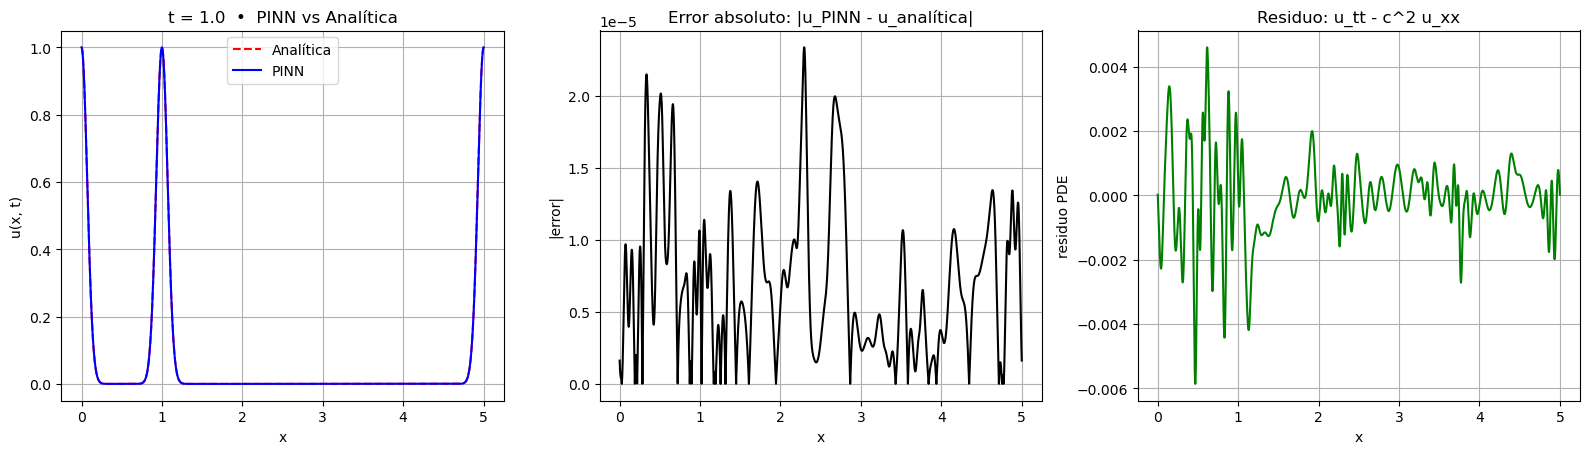

In [111]:
using PyPlot, Statistics

# ---------------------------------------------------------------
# Visualización final: 10 000 puntos, PINN vs. solución analítica
# ---------------------------------------------------------------

t_vis = 1.0 # tiempo para la comparación

# Puntos
Nvis = 20_000
xv   = collect(range(config[:xmin], config[:xmax], length = Nvis))
x    = reshape(xv, 1, :)
y    = fill(t_vis, 1, Nvis)

# Predicción PINN y solución exacta
u_pinn = calculate_f(x, y, NN, Θ, st)
u_true = exact_periodic_solution(
    x, y,
    config[:A], config[:sigma], config[:x0], config[:c], config[:L]
)

u_pinn_vec = vec(u_pinn)
u_true_vec = vec(u_true)

# Error
err_vec = u_pinn_vec .- u_true_vec
abs_err_vec = abs.(err_vec)

# Residuo PDE en cada punto: r = u_tt - c^2 u_xx
_, u_xx, u_tt = calculate_derivatives(x, y, NN, Θ, st)
res_vec = vec(u_tt .- (config[:c]^2) .* u_xx)

# ---------------------------------------------------------------
# Gráficos con PyPlot (tres subplots lado a lado)
# ---------------------------------------------------------------
PyPlot.figure(figsize = (16, 4.8))

# (1) Exacta vs PINN superpuestas
PyPlot.subplot(1, 3, 1)
PyPlot.plot(xv, u_true_vec, "r--", label="Analítica")
PyPlot.plot(xv, u_pinn_vec, "b-",  label="PINN")
PyPlot.xlabel("x"); PyPlot.ylabel("u(x, t)")
PyPlot.title("t = $(round(t_vis, digits=3))  •  PINN vs Analítica")
PyPlot.grid(true); PyPlot.legend(loc="best")

# (2) Error absoluto
PyPlot.subplot(1, 3, 2)
PyPlot.plot(xv, abs_err_vec, "k-")
PyPlot.xlabel("x"); PyPlot.ylabel("|error|")
PyPlot.title("Error absoluto: |u_PINN - u_analítica|")
PyPlot.grid(true)

# (3) Residuo del PDE
PyPlot.subplot(1, 3, 3)
PyPlot.plot(xv, res_vec, "g-")
PyPlot.xlabel("x"); PyPlot.ylabel("residuo PDE")
PyPlot.title("Residuo: u_tt - c^2 u_xx")
PyPlot.grid(true)

PyPlot.tight_layout()
PyPlot.show()

# ---------------------------------------------------------------
# Error absoluto promedio
# ---------------------------------------------------------------
avg_abs_err = mean(abs_err_vec)
println("Error absoluto promedio = $avg_abs_err")
